In [1]:
# Exploration of color transforms, gradients or other methods to create a thresholded binary image

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

%matplotlib inline

In [5]:
# Un-pickle camera calibration
cam_cal = pickle.load(open('cam_calibration.p','rb'))
dist = cam_cal['dist']
mtx = cam_cal['mtx']

In [98]:
# Function to show the 6 test images in a subplot
def show_images(images, cmap=None):
    fig, ax = plt.subplots(3, 2, figsize=(15, 10))
    ax = ax.ravel()
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap=cmap)

In [99]:
image_paths = glob.glob('test_images/test*.jpg')
images = []
for path in image_paths:
    images.append(cv2.imread(path))

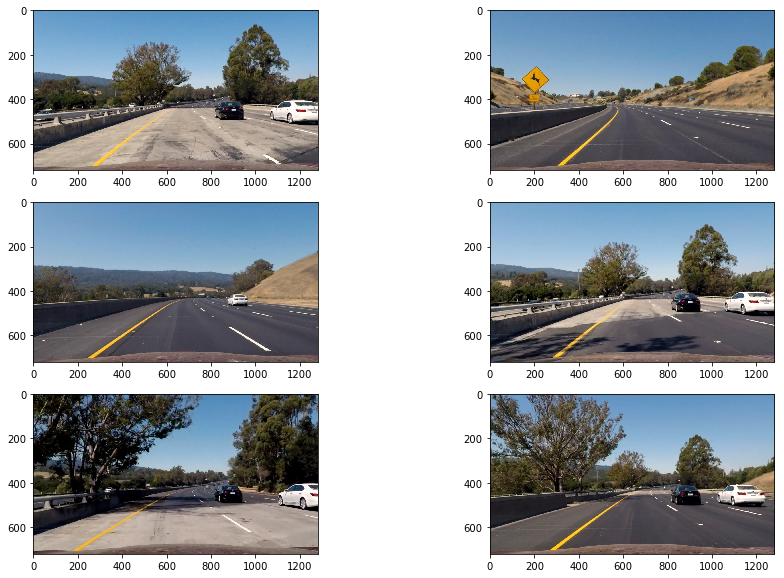

In [100]:
# Undistorting test images

undist_images = []
for img in images:
    undist_images.append(cv2.undistort(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx))
show_images(undist_images)

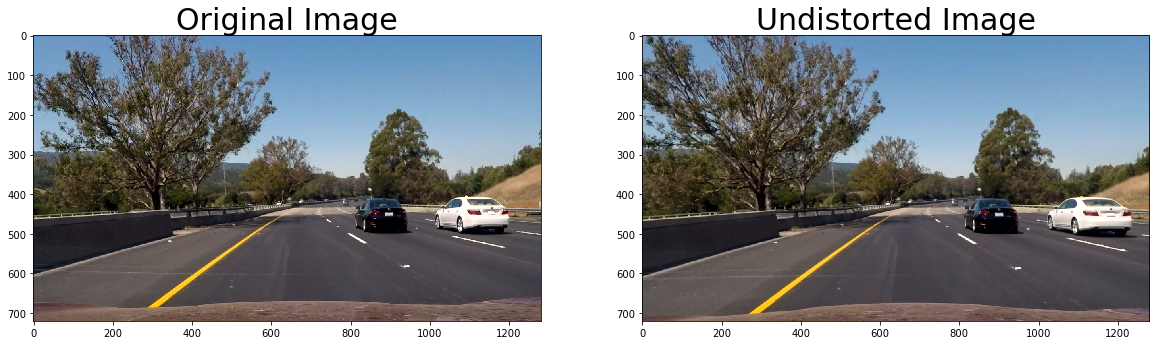

In [71]:
undist_test_img = cv2.imread('test_images/test6.jpg')

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(cv2.cvtColor(undist_test_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=30)
dst = cv2.undistort(undist_test_img, mtx, dist, None, mtx)
ax[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax[1].set_title('Undistorted Image', fontsize=30)

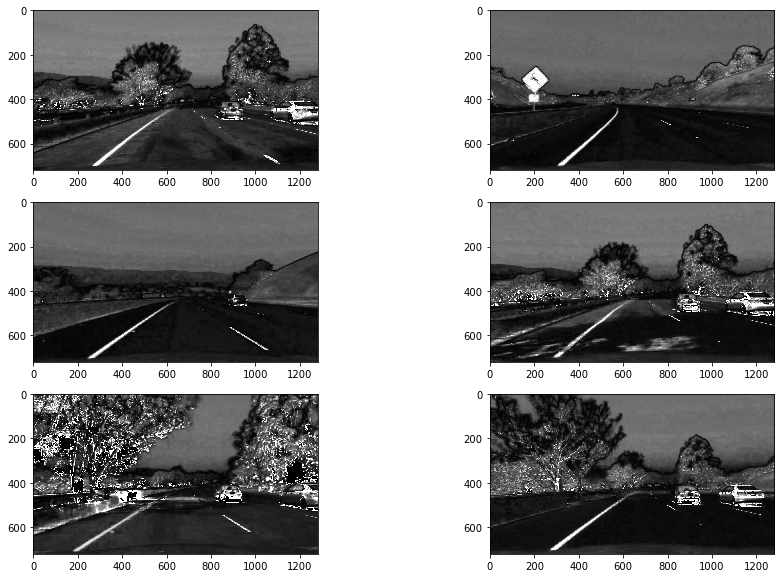

In [72]:
# Convert to HLS and extract S channel

hls_images= []
s_channel_images = []
for img in undist_images:
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls_images.append(hls)
    s_channel_images.append(hls[:,:,2])

show_images(s_channel_images, cmap='gray')

In [86]:
# Gradient thresholds
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(grad_mag)
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

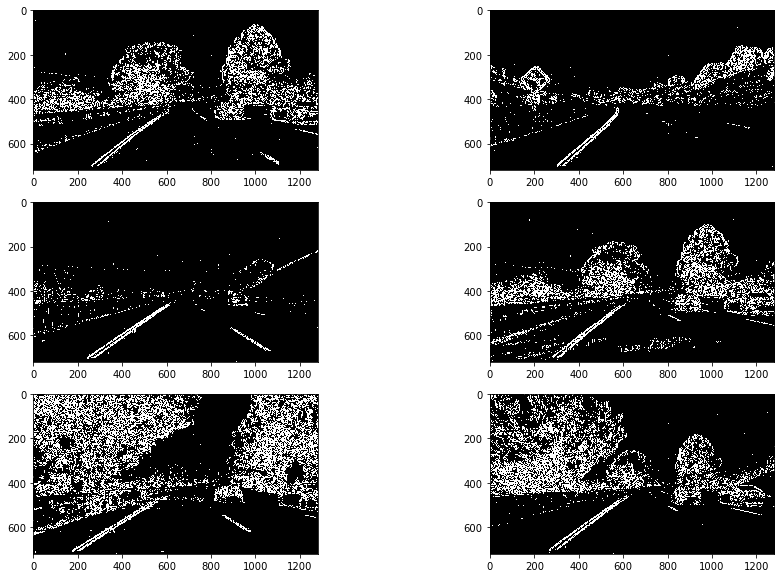

In [79]:

ksize = 3 # Choose a larger odd number to smooth gradient measurements

sobelx_images = []
for img in s_channel_images:
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    sobelx_images.append(gradx)

show_images(sobelx_images, cmap='gray')

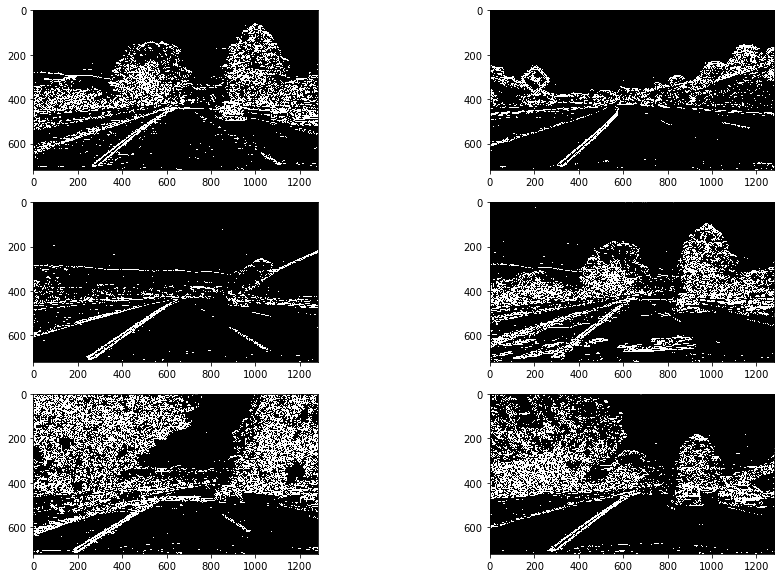

In [80]:
# Sobel Y

sobely_images = []
for img in s_channel_images:
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    sobely_images.append(gradx)

show_images(sobely_images, cmap='gray')

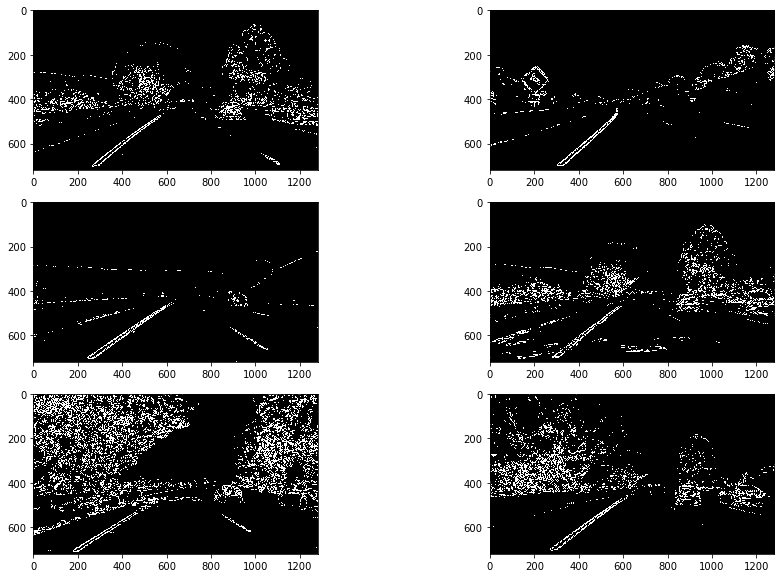

In [82]:
# Magnitude

mag_images = []
for img in s_channel_images:
    mag = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    mag_images.append(mag)

show_images(mag_images, cmap='gray')

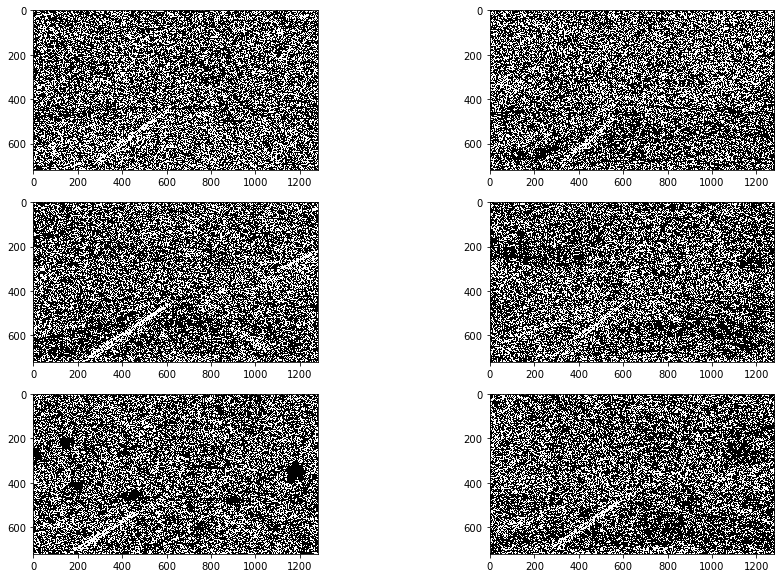

In [88]:
# Directional

direct_images = []
for img in s_channel_images:
    direct = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    direct_images.append(direct)

show_images(direct_images, cmap='gray')

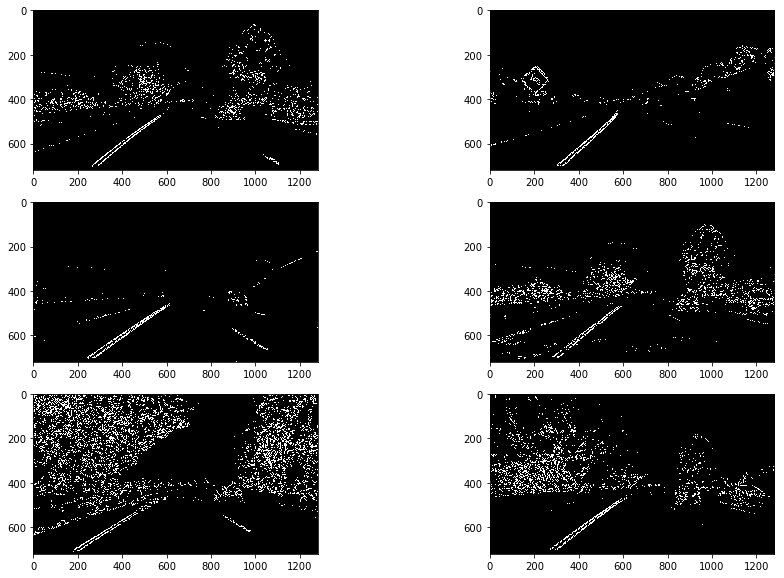

In [94]:
# Combine thresholds
combined_images = []

for i in range(len(sobelx_images)):
    combined = np.zeros_like(sobelx_images[i])
    #combined[((sobelx_images[i] == 1) & (sobely_images[i] == 1)) | ((mag_images[i] == 1) & (direct_images[i] == 1))] = 1
    combined[((sobelx_images[i] == 1) & (sobely_images[i] == 1) & (mag_images[i] == 1))] = 1
    combined_images.append(combined)
                           
show_images(combined_images, cmap='gray')